In [1]:
import sqlite3

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
db = sqlite3.connect('../app/app.db')
db2 = sqlite3.connect('../raw_db.db')

In [3]:
attend_history = pd.read_sql_query(
    """
    SELECT 
        group_id
        , attend_history.user_id
        , is_woman
        , age_group
        , start_date
        , finish_date
        , n_visits
        , attend_history.category3_id
        , category2_id
        , category1_id
        , category3_name
        , category2_name
        , category1_name
    FROM attend_history
    LEFT JOIN users ON attend_history.user_id = users.user_id
    LEFT JOIN categories ON attend_history.category3_id = categories.category3_id
    """, con=db)

In [4]:
future_groups = pd.read_sql_query(
    """
    SELECT 
        group_timetable.group_id
        , categories.category3_id
        , categories.category2_id
        , categories.category1_id
        , category3_name
        , category2_name
        , category1_name
    FROM group_timetable
    LEFT JOIN groups ON group_timetable.group_id = groups.group_id
    LEFT JOIN categories ON groups.category3_id = categories.category3_id
    """, con=db)

In [5]:
future_groups.groupby(['category1_name', 'category2_name', 'category3_name']).agg({'group_id': 'count'})

group_id
category1_name        category2_name        category3_name                          
Игры                  Интеллектуальные игры Иные интеллектуальные игры             9
                      Настольные игры       Иные настольные игры                   1
                      Шахматы и шашки       Шахматы                                2
                                            Шахматы и шашки                        2
Образование           Английский язык       Английский язык для начинающих        16
...                                                                              ...
Физическая активность Фитнес, тренажеры     Степ-аэробика                          2
                                            Стрейчинг                             14
                                            Танцевальная физкультура               1
                                            Тренажеры                              9
                                            Фитнес                                 1

[141 rows x 1 columns]

In [6]:
attend_history['start_date'] = pd.to_datetime(attend_history['start_date'])
attend_history['finish_date'] = pd.to_datetime(attend_history['finish_date'])

In [7]:
attend_history['n_calendar_days'] = (attend_history['finish_date'] - attend_history['start_date']).apply(lambda x: x.days) + 1

In [8]:
attend_history['n_days_passed'] = (pd.to_datetime('2023-03-01') - attend_history['finish_date']).apply(lambda x: x.days) + 1

In [9]:
attend_history[['n_visits', 'n_calendar_days', 'n_days_passed']].describe()

,n_visits,n_calendar_days,n_days_passed
count,600185.000000,600185.000000,600185.000000
mean,9.831597,68.519353,97.038596
std,13.000961,84.284283,94.719193
min,1.000000,1.000000,2.000000
25%,2.000000,8.000000,14.000000
50%,5.000000,36.000000,66.000000
75%,12.000000,92.000000,147.000000
max,94.000000,334.000000,335.000000


In [10]:
attend_history_agg = attend_history.groupby(['category3_id', 'category1_name', 'category2_name', 'category3_name', 'user_id'], as_index=False).agg({
    'start_date': 'min',
    'finish_date': 'max',
    'n_visits': 'sum',
    'group_id': 'count'
})

attend_history_agg['n_calendar_days'] = (attend_history_agg['finish_date'] - attend_history_agg['start_date']).apply(lambda x: x.days) + 1
attend_history_agg['n_days_passed'] = (pd.to_datetime('2023-03-01') - attend_history_agg['finish_date']).apply(lambda x: x.days) + 1

In [11]:
attend_history_agg

,category3_id,category1_name,category2_name,category3_name,user_id,start_date,finish_date,n_visits,group_id,n_calendar_days,n_days_passed
0,102,Физическая активность,Спортивные игры,Иные подвижные игры,101346828,2022-08-02,2022-08-09,3,1,8,205
1,102,Физическая активность,Спортивные игры,Иные подвижные игры,101346919,2023-02-07,2023-02-28,5,1,22,2
2,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347130,2022-06-16,2023-02-28,61,3,258,2
3,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347613,2022-11-16,2022-12-07,4,1,22,85
4,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347678,2023-02-15,2023-02-15,1,1,1,15
...,...,...,...,...,...,...,...,...,...,...,...
279680,1813,Образование,Образовательный практикум,Кинолекторий,101447511,2023-02-20,2023-02-27,2,1,8,3
279681,1813,Образование,Образовательный практикум,Кинолекторий,101447556,2023-01-25,2023-01-25,1,1,1,36
279682,1813,Образование,Образовательный практикум,Кинолекторий,101447711,2023-01-25,2023-02-27,9,2,34,3
279683,1813,Образование,Образовательный практикум,Кинолекторий,101447727,2023-01-25,2023-02-27,8,2,34,3


In [12]:
attend_history_agg['freq'] = (attend_history_agg['n_visits'] / attend_history_agg['n_calendar_days'])

In [13]:
attend_history_agg

,category3_id,category1_name,category2_name,category3_name,user_id,start_date,finish_date,n_visits,group_id,n_calendar_days,n_days_passed,freq
0,102,Физическая активность,Спортивные игры,Иные подвижные игры,101346828,2022-08-02,2022-08-09,3,1,8,205,0.375000
1,102,Физическая активность,Спортивные игры,Иные подвижные игры,101346919,2023-02-07,2023-02-28,5,1,22,2,0.227273
2,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347130,2022-06-16,2023-02-28,61,3,258,2,0.236434
3,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347613,2022-11-16,2022-12-07,4,1,22,85,0.181818
4,102,Физическая активность,Спортивные игры,Иные подвижные игры,101347678,2023-02-15,2023-02-15,1,1,1,15,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
279680,1813,Образование,Образовательный практикум,Кинолекторий,101447511,2023-02-20,2023-02-27,2,1,8,3,0.250000
279681,1813,Образование,Образовательный практикум,Кинолекторий,101447556,2023-01-25,2023-01-25,1,1,1,36,1.000000
279682,1813,Образование,Образовательный практикум,Кинолекторий,101447711,2023-01-25,2023-02-27,9,2,34,3,0.264706
279683,1813,Образование,Образовательный практикум,Кинолекторий,101447727,2023-01-25,2023-02-27,8,2,34,3,0.235294


In [14]:
attend_history_agg2 = attend_history_agg.groupby(['category1_name', 'category2_name', 'category3_name'], as_index=False).agg({
    'user_id': 'count',
    'n_calendar_days': ['mean', 'std'],
    'n_days_passed': ['mean', 'std'],
    'n_visits': ['mean', 'std'],
})

<AxesSubplot:>

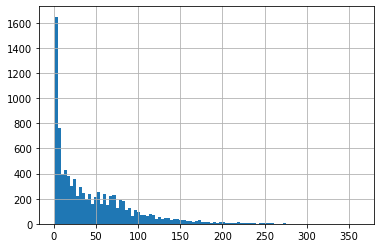

In [15]:
attend_history_agg[attend_history_agg['category3_name'] == 'Мастер-класс по уходу за кожей в зрелом возрасте']['n_visits'].hist(bins=100)

<AxesSubplot:>

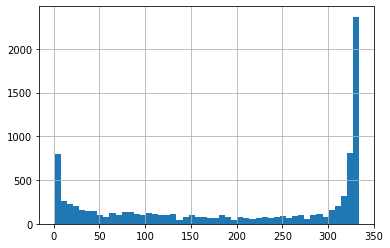

In [16]:
attend_history_agg[attend_history_agg['category3_name'] == 'Мастер-класс по уходу за кожей в зрелом возрасте']['n_calendar_days'].hist(bins=50)

<AxesSubplot:>

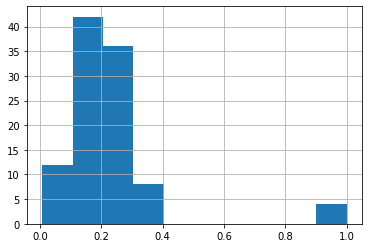

In [17]:
attend_history_agg[attend_history_agg['category3_name'] == 'Футбол']['freq'].hist()

**Квантили интереса (кол-во дней)**

In [18]:
attend_history_agg_days = attend_history_agg.groupby('category3_id', as_index=False).agg({'user_id': 'count', 'n_visits': list, 'n_calendar_days': list})

In [19]:
for name in ['n_visits', 'n_calendar_days']:
    attend_history_agg_days[name] = attend_history_agg_days[name].apply(lambda x: np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 1]).round())

In [20]:
attend_history_agg_days = attend_history_agg_days[attend_history_agg_days['user_id'] >= 10]

In [21]:
attend_history_agg_days.head()

,category3_id,user_id,n_visits,n_calendar_days
0,102,269,"[1.0, 4.0, 10.0, 24.0, 27.0, 43.0, 53.0, 66.0,...","[1.0, 22.0, 90.0, 183.0, 205.0, 272.0, 281.0, ..."
1,104,6985,"[2.0, 5.0, 15.0, 34.0, 40.0, 57.0, 73.0, 125.0...","[5.0, 34.0, 113.0, 260.0, 302.0, 328.0, 330.0,..."
2,111,102,"[3.0, 7.0, 32.0, 60.0, 71.0, 84.0, 90.0, 108.0...","[17.0, 52.0, 229.0, 329.0, 330.0, 330.0, 331.0..."
3,112,5247,"[1.0, 4.0, 13.0, 37.0, 44.0, 67.0, 87.0, 145.0...","[1.0, 22.0, 120.0, 295.0, 316.0, 329.0, 330.0,..."
4,114,7675,"[1.0, 4.0, 13.0, 34.0, 40.0, 58.0, 72.0, 105.0...","[1.0, 29.0, 118.0, 267.0, 304.0, 328.0, 330.0,..."


In [22]:
long_quantiles_n_visits = []

for row in attend_history_agg_days.values:
    for n_v, q in zip(row[2], range(2, 11)):
        long_quantiles_n_visits.append((row[0], q, n_v))
        
long_quantiles_n_visits = pd.DataFrame(long_quantiles_n_visits, columns=['category3_id', 'qt', 'n_visits'])

In [23]:
long_quantiles_n_visits = long_quantiles_n_visits.drop_duplicates(subset=['category3_id', 'n_visits'], keep='last')

In [24]:
long_quantiles_n_visits

,category3_id,qt,n_visits
0,102,2,1.0
1,102,3,4.0
2,102,4,10.0
3,102,5,24.0
4,102,6,27.0
...,...,...,...
2326,1813,6,6.0
2327,1813,7,8.0
2328,1813,8,9.0
2329,1813,9,11.0


In [25]:
long_quantiles_n_visits.to_csv('category_quantiles.csv', index=None)

## Промежутки возвращения

In [26]:
attend_raw = pd.read_sql("""
SELECT user_id, event_date, category3_id
FROM attend
LEFT JOIN groups ON attend.group_id = groups.group_id
WHERE category3_id IS NOT NULL
""", con=db2)
attend_raw['event_date'] = pd.to_datetime(attend_raw['event_date'])
attend_raw = attend_raw.groupby(['user_id', 'category3_id'], as_index=False).agg({'event_date': lambda x: sorted(list(x))})

In [27]:
attend_raw.head()

,user_id,category3_id,event_date
0,101346549,114,[2023-02-13 00:00:00]
1,101346549,121,[2023-02-24 00:00:00]
2,101346549,142,"[2023-02-20 00:00:00, 2023-02-22 00:00:00]"
3,101346549,170,[2023-01-25 00:00:00]
4,101346549,204,"[2023-01-12 00:00:00, 2023-02-09 00:00:00]"


In [28]:
attend_raw['ith'] = attend_raw['event_date'].apply(lambda x: range(1, len(x)))

In [29]:
attend_raw['diff_days'] = attend_raw['event_date'].apply(lambda x: [(e - s).days for s, e in zip(x[:-1], x[1:])])

In [30]:
long_attend = []

for row in attend_raw.values:
    if len(row[-1]) > 0:
        for i, d in zip(row[-2], row[-1]):
            long_attend.append((row[1], i, d))
            
long_attend = pd.DataFrame(long_attend, columns=['category3_id', 'ith', 'diff'])

<AxesSubplot:>

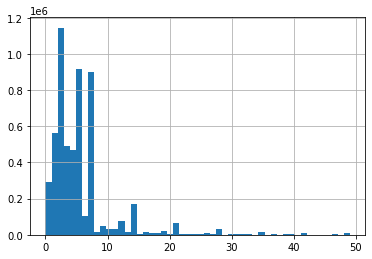

In [31]:
long_attend[(long_attend['diff'] < 50) & (long_attend['ith'] > 0)]['diff'].hist(bins=50)

**95% перцентиль времени возврата**

In [32]:
likely_come_back = long_attend.groupby('category3_id', as_index=False).agg({'ith': 'count', 'diff': lambda x: np.ceil(np.percentile(x, 95))}).astype(int)

In [33]:
likely_come_back = likely_come_back[likely_come_back['ith'] >= 100].drop('ith', axis=1)

In [34]:
likely_come_back.to_csv('likely_come_back_days.csv', index=None)

## Модель

In [36]:
attend_history = pd.read_sql("""
    SELECT user_id, category3_id, sum(n_visits) as n_visits
    FROM attend_history
    GROUP BY user_id, category3_id
""", con=db)

In [37]:
attend_history

,user_id,category3_id,n_visits
0,101346549,114,1
1,101346549,121,1
2,101346549,142,2
3,101346549,170,1
4,101346549,204,2
...,...,...,...
279680,101449498,327,3
279681,101449549,114,1
279682,101449549,178,2
279683,101449549,218,1


In [38]:
attend_history_agg_days = attend_history_agg_days[['category3_id', 'n_visits']]
attend_history_agg_days.columns = ['category3_id', 'quantiles']

In [41]:
attend_history2 = attend_history.groupby(['user_id', 'category3_id'], as_index=False).agg({'n_visits': 'sum'})

In [42]:
attend_history2 = attend_history2.merge(attend_history_agg_days)

In [43]:
attend_history2['this_quantile'] = attend_history2.apply(
    lambda x: max([i + 2 for i, v in enumerate(x['quantiles']) if v <= x['n_visits']] + [1])
    , axis=1
)

In [44]:
attend_history2[['user_id', 'category3_id', 'this_quantile']].to_csv('user_cat_quantile.csv', index=None)

## Знакомства

In [397]:
attend_raw = pd.read_sql("""
SELECT user_id, event_date, group_id
FROM attend
-- LEFT JOIN groups ON attend.group_id = groups.group_id
-- WHERE category3_id IS NOT NULL
""", con=db2)

In [398]:
attend_raw = attend_raw.groupby(['group_id', 'event_date'], as_index=False).agg({'user_id': list})

In [399]:
attend_raw = attend_raw[attend_raw['user_id'].apply(len) > 1]

In [400]:
from collections import defaultdict

In [401]:
dct = defaultdict(lambda: defaultdict(int))

for row in tqdm(attend_raw.values):
    for user in row[-1]:
        for friend in row[-1]:
            if friend != user:
                dct[user][friend] += 1

  0%|          | 0/595379 [00:00<?, ?it/s]

In [402]:
from itertools import chain

In [403]:
attend_raw = attend_raw.groupby('group_id', as_index=False).agg({'user_id': lambda x: set(list(chain(*x)))})

In [405]:
attend_raw.head()

,group_id,user_id
0,801346549,"{101370217, 101392971}"
1,801346550,"{101421312, 101425664, 101354499, 101431176, 1..."
2,801346551,"{101394946, 101411459, 101380356, 101348358, 1..."
3,801346552,"{101388171, 101432990, 101435683, 101384874, 1..."
4,801346553,"{101367811, 101360645, 101360904, 101357321, 1..."


In [406]:
user_group = []
for group, users in attend_raw.values:
    for user in users:
        a = 0
        t = 0
        for friend in users:
            if friend != user:
                if dct[user][friend] > 10:
                    t += 1
                a += 1
        user_group.append((user, group, a, t))

In [407]:
user_group = pd.DataFrame(user_group, columns=['user_id', 'group_id', 'meet', 'meet10'])

user_group.head(10)

,user_id,group_id,meet,meet10
0,101370217,801346549,1,0
1,101392971,801346549,1,0
2,101421312,801346550,29,18
3,101425664,801346550,29,18
4,101354499,801346550,29,16
5,101431176,801346550,29,12
6,101407247,801346550,29,1
7,101417874,801346550,29,12
8,101411605,801346550,29,18
9,101422869,801346550,29,12


In [408]:
user_group.to_csv('friends.csv', index=None)

## Запись в базу

In [45]:
data = pd.read_csv('./category_quantiles.csv')
data.head()

,category3_id,qt,n_visits
0,102,2,1.0
1,102,3,4.0
2,102,4,10.0
3,102,5,24.0
4,102,6,27.0


In [46]:
cursor = db.cursor()

In [342]:
cursor.execute("""
CREATE TABLE category_quantiles (
    category3_id INTEGER, 
    qt INTEGER, 
    n_visits INTEGER, 
    PRIMARY KEY (category3_id, qt)
)
""")
db.commit()

In [47]:
data.to_sql('category_quantiles', con=db, index=None, if_exists='replace')

2189

In [48]:
data = pd.read_csv('./likely_come_back_days.csv')
data.columns = ['category3_id', 'n_days_max']
data.head()

,category3_id,n_days_max
0,102,21
1,104,16
2,111,12
3,112,16
4,114,19


In [ ]:
cursor.execute("""
CREATE TABLE no_activity_limit (
    category3_id INTEGER, 
    n_days_max INTEGER, 
    PRIMARY KEY (category3_id)
)
""")
db.commit()

In [50]:
data.to_sql('no_activity_limit', con=db, index=None, if_exists='replace')

246

In [51]:
data = pd.read_csv('./user_cat_quantile.csv')
data.columns = ['user_id', 'category3_id', 'user_quantile']
data.head()

,user_id,category3_id,user_quantile
0,101346549,114,2
1,101346558,114,4
2,101346581,114,2
3,101346596,114,4
4,101346601,114,2


In [ ]:
cursor.execute("""
CREATE TABLE user_category_quantile (
    user_id INTEGER, 
    category3_id INTEGER, 
    user_quantile INTEGER, 
    PRIMARY KEY (user_id, category3_id)
)
""")
db.commit()

In [53]:
data.to_sql('user_category_quantile', con=db, index=None, if_exists='replace')

279496

In [382]:
cursor.execute("""
CREATE TABLE friends (
    user_id INTEGER, 
    group_id INTEGER, 
    meet INTEGER, 
    meet10 INTEGER,
    PRIMARY KEY (user_id, group_id)
)
""")
db.commit()

In [409]:
data = pd.read_csv('./friends.csv')
data.head()

,user_id,group_id,meet,meet10
0,101370217,801346549,1,0
1,101392971,801346549,1,0
2,101421312,801346550,29,18
3,101425664,801346550,29,18
4,101354499,801346550,29,16


In [410]:
data.to_sql('friends', con=db, index=None, if_exists='replace')

598087